<a href="https://colab.research.google.com/github/GiordanoSM/Audio-Equalizer---Web-Python/blob/main/SimuLTE_UE_limit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotly



Importar as bibliotecas do Pandas, Numpy, Sklearn



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px

from sklearn.metrics import classification_report

import io
import requests

Comando para pegar o arquivo .csv:

    scavetool x *.sca -o exemplo.csv

**COV**

For menor ou igual a 15% → baixa dispersão: dados homogêneos

For entre 15 e 30% → média dispersão

For maior que 30% → alta dispersão: dados heterogêneos

# Simulações 1 - Teste dos UEs



## Configurações

> 10s de duração

> 10 repetições

> Rede SimpleNet (1 enB)

> **Apps:** UE - VoIPSender; Server - VoIPReceiver ----- VoIP UL

> **Tamanho dos pacotes:** 40 bytes

> Cenário = ITU Urban Macro-cell

> UEs distribuídas uniformemente em um círculo de raio 288.675m em torno do eNB

> Carrier Frequency = 2 GHz

> Antena omnidirecional

> Modelo de propagação = Free Space Model

> Tipo de fading = JAKES

## Parâmetros

### Escalonadores

> MAXCI: Maximum Carrier-over-Interference

> DRR: Deficit round-robin

> PF: Proportional fair

> ALLOCATOR_BESTFIT

### NumUes

> 30, 60

**Topologia:** 

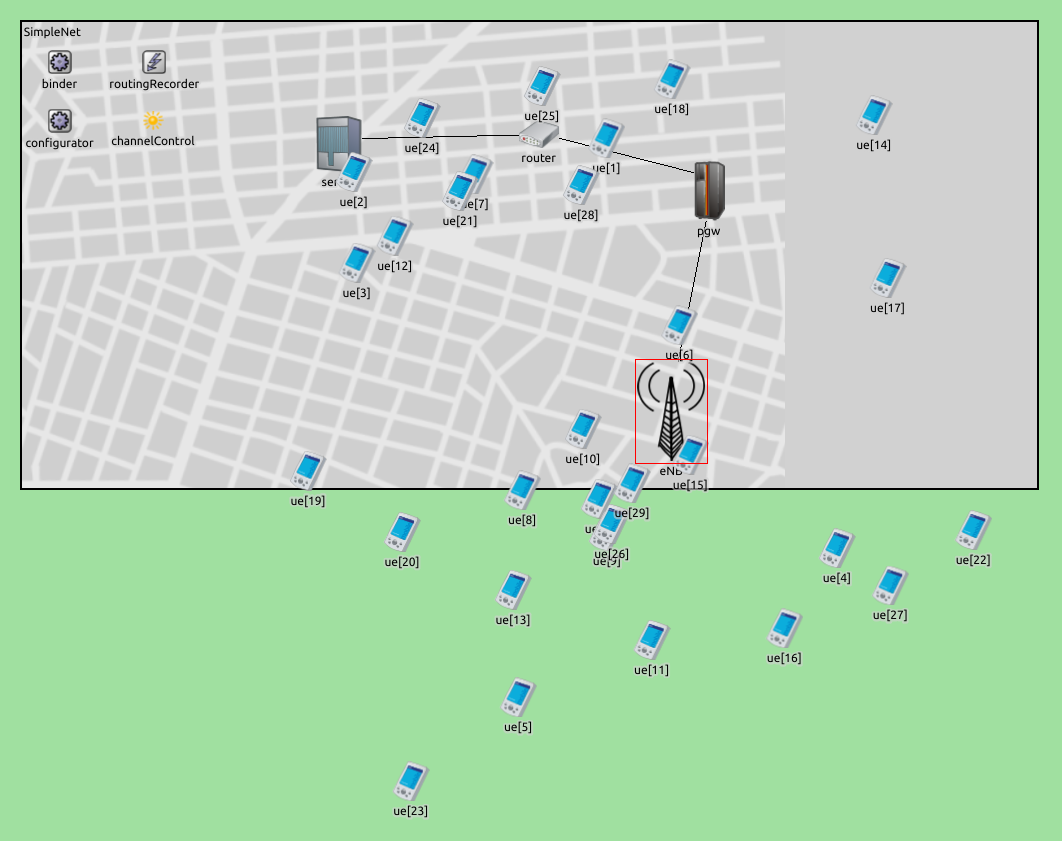

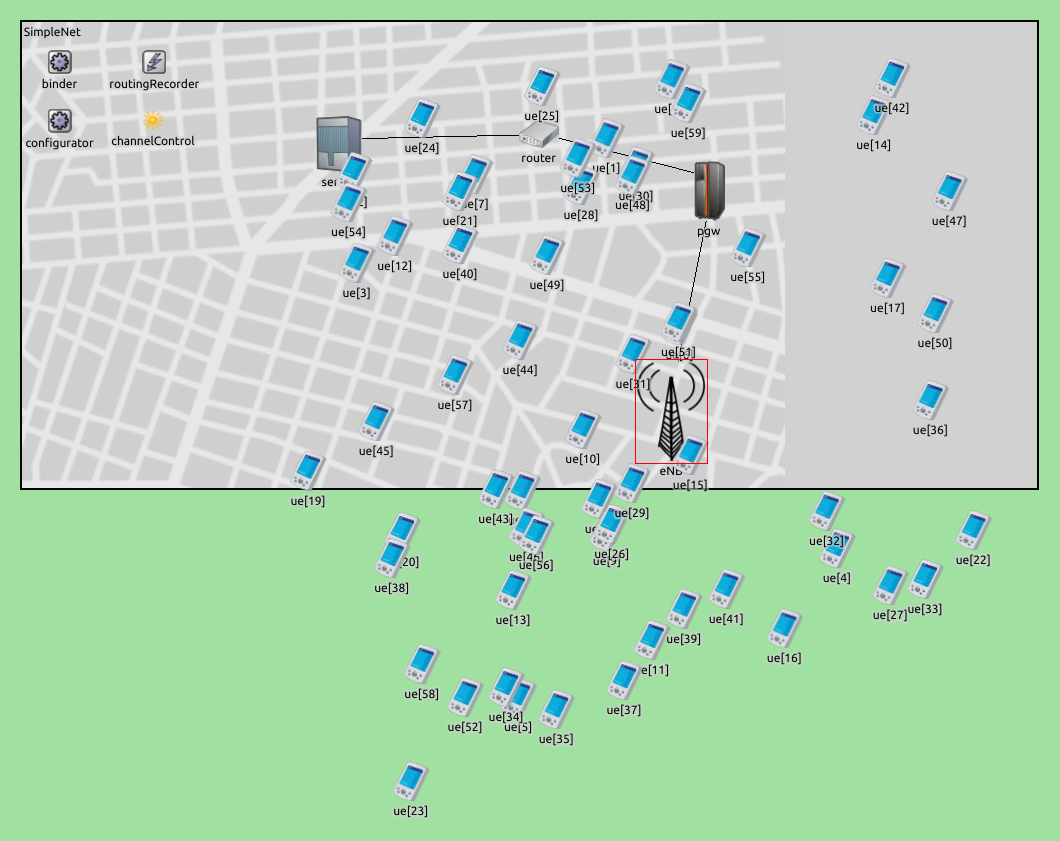

Leitura dos Dados

In [ ]:
initialData = pd.read_csv('testeUEs_10.csv')
#url = 'https://drive.google.com/uc?id=1Jmz-JmOmGtOgQhoQzz9JKbNFluD28RE3'#'https://raw.githubusercontent.com/GiordanoSM/SimuLTE-Dados/master/simple_sched_test.csv'
#initialData=pd.read_csv(url)

Atributos: run,type,module,name,attrname,attrvalue,value

In [ ]:
initialData

,run,type,module,name,attrname,attrvalue,value
0,VoIP_Simple_UeTest-11-20210701-16:45:55-3208,runattr,NaN,NaN,configname,VoIP_Simple_UeTest,NaN
1,VoIP_Simple_UeTest-11-20210701-16:45:55-3208,runattr,NaN,NaN,datetime,20210701-16:45:55,NaN
2,VoIP_Simple_UeTest-11-20210701-16:45:55-3208,runattr,NaN,NaN,experiment,VoIP_Simple_UeTest,NaN
3,VoIP_Simple_UeTest-11-20210701-16:45:55-3208,runattr,NaN,NaN,inifile,simple.ini,NaN
4,VoIP_Simple_UeTest-11-20210701-16:45:55-3208,runattr,NaN,NaN,iterationvars,"$r=288.675m*sqrt(uniform(0, 1, 1)), $theta=2m ...",NaN
...,...,...,...,...,...,...,...
137355,VoIP_Simple_UeTest-69-20210701-17:13:09-3208,attr,SimpleNet.ue[58].app[0],voIPGeneratedThroughput:mean,unit,Bps,NaN
137356,VoIP_Simple_UeTest-69-20210701-17:13:09-3208,scalar,SimpleNet.ue[59].app[0],voIPGeneratedThroughput:mean,NaN,NaN,1871.98695
137357,VoIP_Simple_UeTest-69-20210701-17:13:09-3208,attr,SimpleNet.ue[59].app[0],voIPGeneratedThroughput:mean,source,voIPGeneratedThroughput,NaN
137358,VoIP_Simple_UeTest-69-20210701-17:13:09-3208,attr,SimpleNet.ue[59].app[0],voIPGeneratedThroughput:mean,title,"Throughput generated by the application, mean",NaN


Remover instâncias com valores ausentes e pegar informações gerais



In [ ]:
initialData = initialData.replace(('?'),np.NaN)

#runs = dataInfo['run'].unique()

modules = initialData["module"].unique()

itervar = initialData[initialData['type'] == "itervar"]
runattr = initialData[initialData['type'] == "runattr"]
param = initialData[initialData['type'] == "param"]
scalar = initialData[initialData['type'] == "scalar"]
attr = initialData[initialData['type'] == "attr"]

infoNameAttr = initialData["type"].unique()

In [ ]:
repetitions = int(runattr[runattr["attrname"] == 'repetition']["attrvalue"].max()) + 1 #Número de repetições feitas

Itervar processing

In [ ]:
preItervar = itervar.pivot('run', columns='attrname', values='attrvalue').astype({"numUEs": int, "sched": object})

In [ ]:
#preItervar

Runattr processing

In [ ]:
preRunattr = runattr.pivot('run', columns='attrname', values='attrvalue').astype({"repetition": int})

In [ ]:
#preRunattr

Scalar data pre-processing

In [ ]:
preScalar = scalar
preScalar = preScalar[preScalar.module != "_runattrs_"]

preData = preScalar.assign(qname = preScalar.module.str.replace('SimpleNet\.', '') + '.' + preScalar.name)

In [ ]:
#modules

**Função que calcula o COV**

In [ ]:
#Requer um dataframe com a coluna config, os nomes a serem considerados, a coluna com os valores e o número de repetições.
def getCOV(data, names, value_name: str, repetitions):

  results_rtm = []
  for n in names:
    results_rtm.append(data[data.config == n][value_name].sum()/repetitions)

  covData = pd.DataFrame(index= names, columns= ['Mean'], data= results_rtm)

  DP = [np.sqrt(np.sum(np.square(data[data.config == case][value_name].to_numpy() - covData['Mean'].loc[case]))/repetitions) for case in names]

  COV = [x/y for x,y in zip(DP,results_rtm)]

  temp_nUes = []
  temp_sched = []
  for n in names:
    l = n.split('_', 1)
    temp_nUes.append(l[0])
    temp_sched.append(l[1])

  covData = covData.assign(DP = DP, COV = COV, numUEs = temp_nUes, sched = temp_sched)
  return covData

**Received Throughput**

In [ ]:
newData = preData[preData["name"] == "voIPReceivedThroughput:mean"] #Pega somente os valores de voIPReceivedThroughput:mean
newData = newData.pivot('run', columns='qname', values='value')
newData = newData.combine_first(preItervar) #Coloca os valores de sched, pktSize e numUEs no DataFrame

workingUEs = newData.numUEs.max() - newData.isnull().sum(axis=1) #Número de apps do servidor que recebeu informações dos UEs
nanNumber = newData.numUEs - workingUEs #Numero de Apps do servidor com resultados NaN
plotData = newData.assign(nanNumber = nanNumber, workingUEs=  workingUEs)
plotData = plotData.assign(repetition = preRunattr["repetition"])

#Preparação para pode usar a função getCOV
names = plotData['numUEs'].astype(str) + '_' + plotData2.sched
names_u = names.unique()
plotData = plotData.assign(config = names)

covDatatmp = getCOV(plotData, names_u, "nanNumber", repetitions)

**Número apps do servidor que n sem dados dos UEs** 

1.   nanNumber representa a número de apps do servidor com throughout NaN
2.   Cada cor representa um escalonador
3.   Cada divisória na coluna representa uma repetição

In [ ]:
fig = px.bar(plotData, x="numUEs", y="nanNumber",
             color='sched', barmode='group',
             hover_data = ['workingUEs', 'repetition'], height=400, title= 'Número apps do servidor sem dados dos UEs')
fig.show()

In [ ]:
fig = px.bar(covData, x="numUEs", y="Mean",
             color='sched', barmode='group',
             hover_data = ['COV', 'DP'], height=400, title= 'Média entre as repetições - apps sem dados')
fig.show()

fig = px.bar(covData, x="numUEs", y="COV",
             color='sched', barmode='group',
             hover_data = ['Mean', 'DP'], height=400, title= 'Coeficiente de variação (COV) - apps sem dados')
fig.show()

**Plot do throughput médio recebido pelo servidor (média todos os apps)**



1.   Valor do throughput usado é a média do throughput recebido por todos os apps
2.   Cores representam os escalonadores
3.   Separações em cada coluna são as repetições

In [ ]:
receivedThroughputMean = newData.sum(axis=1) / newData.numUEs #Média do throughput de todos os apps do servidor
plotData2 = plotData.assign(receivedThroughputMean = receivedThroughputMean)

#Preparação para pode usar a função getCOV
names = plotData2['numUEs'].astype(str) + '_' + plotData2.sched
names_u = names.unique()
plotData2 = plotData2.assign(config = names)

covData = getCOV(plotData2, names_u, "receivedThroughputMean", repetitions)

In [ ]:
names = plotData2['numUEs'].astype(str) + '_' + plotData2.sched
names_u = names.unique()

plotData2 = plotData2.assign(config = names)

covData = getCOV(plotData2, names_u, "receivedThroughputMean", repetitions)

In [ ]:
fig = px.bar(plotData2, x="numUEs", y="receivedThroughputMean",
             color='sched', barmode='group',
             hover_data = ['workingUEs', 'repetition'], height=400, title= 'Média do throughput de todos os apps do servidor')
fig.show()

In [ ]:
fig = px.bar(covData, x="numUEs", y="Mean",
             color='sched', barmode='group',
             hover_data = ['COV', 'DP'], height=400, title= 'Média entre as repetições - todos os Apps')
fig.show()

fig = px.bar(covData, x="numUEs", y="COV",
             color='sched', barmode='group',
             hover_data = ['Mean', 'DP'], height=400, title= 'Coeficiente de variação (COV) - todos os Apps')
fig.show()

**Plot do throughput médio dos apps em que houve recepção de dados** 



1.   Não considerando os que deram NaN



In [ ]:
receivedThroughputMeanWorking = newData.sum(axis=1) / plotData.workingUEs #Média do throughput dos apps do servidor diferentes de NaN
plotData3 = plotData2.assign(receivedThroughputMeanWorking = receivedThroughputMeanWorking)
covData2 = getCOV(plotData3, names_u, "receivedThroughputMeanWorking", repetitions)

In [ ]:
fig = px.bar(plotData3, x="numUEs", y="receivedThroughputMeanWorking",
             color='sched', barmode='group',
             hover_data = ['workingUEs', 'repetition'], height=400)
fig.show()

In [ ]:
fig = px.bar(covData2, x="numUEs", y="Mean",
             color='sched', barmode='group',
             hover_data = ['COV', 'DP'], height=400, title= 'Média entre as repetições - Apps funcionando')
fig.show()

fig = px.bar(covData2, x="numUEs", y="COV",
             color='sched', barmode='group',
             hover_data = ['Mean', 'DP'], height=400, title= 'Coeficiente de variação (COV) - Apps funcionando')
fig.show()

In [ ]:
covDataUE0 = getCOV(plotData2, names_u, "server.app[0].voIPReceivedThroughput:mean", repetitions)
covDataUE1 = getCOV(plotData2, names_u, "server.app[1].voIPReceivedThroughput:mean", repetitions)

In [ ]:
fig = px.bar(plotData3, x="numUEs", y="server.app[0].voIPReceivedThroughput:mean",
             color='sched', barmode='group',
             hover_data = ['workingUEs', 'repetition'], height=400, title= 'Throughput recebido do UE0')
fig.show()
fig = px.bar(plotData3, x="numUEs", y="server.app[1].voIPReceivedThroughput:mean",
             color='sched', barmode='group',
             hover_data = ['workingUEs', 'repetition'], height=400, title= 'Throughput recebido do UE1')
fig.show()

In [ ]:
fig = px.bar(covDataUE0, x="numUEs", y="Mean",
             color='sched', barmode='group',
             hover_data = ['COV', 'DP'], height=400, title= 'Média UE0')
fig.show()
fig = px.bar(covDataUE1, x="numUEs", y="Mean",
             color='sched', barmode='group',
             hover_data = ['COV', 'DP'], height=400, title= 'Média UE1')
fig.show()

In [ ]:
fig = px.bar(covDataUE0, x="numUEs", y="COV",
             color='sched', barmode='group',
             hover_data = ['Mean', 'DP'], height=400, title= 'COV UE0')
fig.show()
fig = px.bar(covDataUE1, x="numUEs", y="COV",
             color='sched', barmode='group',
             hover_data = ['Mean', 'DP'], height=400, title= 'COV UE1')
fig.show()

## **Análise a adicionar:** (3GPP TR 36.814)

For VoIP capacity evaluations, the following performance metrics need to be 

considered:
- VoIP system capacity in form of the maximum number of satisfied users supported per cell in downlink and
uplink.
- System capacity is defined as the number of users in the cell when more than [95%] of the users are satisfied.
- A VoIP user is in outage (not satisfied) if [98%] radio interface tail latency of the user is greater than [50 ms].
This assumes an end-to-end delay below [200 ms] for mobile-to-mobile communications.

## **Mudar parâmetros:**

Antena

Fazer UL e DL

250 = x√3 / 2

x = 288.675

\>=25m

In [ ]:
import random
x = random.randint(0,22)
y = random.randint(0,22)
print(x,y)

1 21
